# MIS 583 Assignment 4: Deep_Fashion_classification

Hi I'm 邱承漢, M104020029

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec  3 06:39:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Based on the outfit images, build a Multitask Learning model to predict categories and attributes simultaneously. <br>
根據衣服圖片，建立一個 Multitask Learning 的模型，同時預測出種類與屬性。

**Multitask : Task 1 - Category**

Multiclass : 10 categories

Goal：Predict the categories(0 - 9) of the outfit, a total of 10 categories.<br>
目標: 預測衣服的種類(0 - 9), 共10類, 如下表: 

```
Label	Category 
---------------------
0	  Dress
1	  Tee
2	  Blouse
3	  Shorts
4	  Tank
5	  Skirt
6	  Cardigan
7	  Sweater
8	  Jacket
9	  Top
```




**Multitask : Task 2 - Attributes**

Multiclass : 15 attributes
Goal：Predict the attributes(0 - 14) of the outfit, a total of 15 attributes, each outfit could have many attributes.<br>
目標：預測衣服的屬性，共15種，同一件衣服可有多個屬性，詳如下表：

```

Label	Attribute
---------------------
0	  print
1	  knit
2	  floral
3	  sleeve
4	  lace
5	  shirt
6	  striped
7	  denim
8	  chiffon
9	  crop
10     maxi
11	 faux
12	 leather
13	 crochet
14	 stripe
```

## Kaggle Competition
  
[**Category**](https://www.kaggle.com/t/5459864722154563af4a3b91eb339f02)

[**Attribute**](https://www.kaggle.com/t/9dc85bed93a2436986bb82f99dc5bb92)

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
torch 1.10.0+cu111
torchvision 0.11.1+cu111


# Prepare Data

DeepFashion 是香港中文大學開放的服裝資料集。

資料中有超過80萬張的圖片，包含不同角度、不同場景等。

每張圖片含有豐富的標籤： (1) 屬於50個類別中的哪類 (2) 擁有1000個屬性中的哪些屬性 (3) 邊框資訊 (4) 特徵點資訊

本作業從原始資料中限縮了10個種類，隨機選出55845張，並挑出1000種屬性中的15種來組成資料。


## How to Get Data

Please open the file `deep_fashion.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/1alC3j-4yaHfZe4bYkr6M7Snxeru4GzYN/view)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `deep_fashion.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1alC3j-4yaHfZe4bYkr6M7Snxeru4GzYN/view)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

---

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip Data

Unzip `deep_fashion.zip`, there are 3 folders and 3 csvs.

- `train/`: contains 5 folders for 5 categories of fashion data. Images of fashiondata inside them.
- `test/`: unclassified images of testing set.
- `train.csv`: file path and true label of training set.
- `val.csv`: file path and true label of validation set.
- `train.csv`: file paht of testing set.

There are ** images in dataset_train.**  
There are ** images in dataset_test.**  
There are ** images in dataset_val.**  

---

解壓縮 `fashiondata.zip` 後可以發現裡面有兩個資料夾和三個csv檔。

+ `train` : 存有五個資料夾分別是五個種類的花，資料夾內為花的照片。
+ `test` : 資料夾中為未分類之測試集照片。
+ `train.csv` : 讀取 train data 的順序、路徑與圖片所屬花別。
+ `val.csv` : 讀取 validate data 的順序、路徑與圖片所屬花別。
+ `test.csv` : 讀取 test data 的順序、路徑。

其中`train`的圖片  1295 張，`val` 的圖片 430 張，`test` 的圖片 431 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [ ]:
!unzip -qq ./drive/MyDrive/Colab\ Notebooks/NSYSU\ IM/深度學習/Assignment4/deep_fashion.zip

In [ ]:
data_folder = 'deep_fashion'

## Loading the dataset


### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

---

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [ ]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FashionData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.category_labels = []
        self.attribute_labels = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{row['file_path']}")
                if mode != 'test':
                    self.category_labels.append(row['category_label'])
                    self.attribute_labels.append(row['attribute_label'])

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        category_label = torch.tensor(int(self.category_labels[index]))
        attribute_label = torch.tensor([int(i) for i in self.attribute_labels[index].split()]) #!!!
        attribute_label = torch.zeros(15).scatter_(0, attribute_label, 1)
        #print(attribute_label)
        return data, category_label, attribute_label 
 
    def __len__(self):
        return len(self.data_list)

In [ ]:
# multi-label -> one-hot
labels = torch.tensor([1, 4, 1, 0, 5, 2])
torch.zeros(15).scatter_(0, labels, 1)

tensor([1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [ ]:
from torchvision import transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train = transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.CenterCrop((224,224)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=(-90, 90)),
  transforms.ToTensor(),
  #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])  
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.CenterCrop((224,224)),
  transforms.ToTensor(),
  #transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
########################################################################
#                           End of your code                           #
########################################################################

### Instantiate dataset

Let's instantiate three `FashionData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [ ]:
dataset_train = FashionData('train.csv', mode='train', transform=transforms_train)
dataset_val = FashionData('val.csv', mode='val', transform=transforms_test)
dataset_test = FashionData('test.csv', mode='test', transform=transforms_test)

In [ ]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(1)[0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 39092 images in dataset_train.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
num_workers = 2
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a fashion image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [ ]:
import torchvision.models as models
import torch.nn as nn 

MODELS = {
	#"vgg16": models.vgg16(pretrained=True),
	"inception": models.inception_v3(pretrained=True),
	"densenet": models.densenet121(pretrained=True),
	"resnet18": models.resnet18(pretrained=True),
	"resnet50": models.resnet50(pretrained=True),
  "resnet101": models.resnet101(pretrained=True)
}

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:


class Double_Head_Linear(torch.nn.Module):
    def __init__(self, Linear1, Linear2):
        super(Double_Head_Linear, self).__init__()
        self.linear1 = Linear1
        self.linear2 = Linear2

    def forward(self, input):
        return self.linear1(input), self.linear2(input)

class CNN_Model(nn.Module): 
    def __init__(self): 
        super().__init__()

        #self.cnn_model = torch.nn.Sequential(*(list(MODELS['resnet18'].children())[:-1]))
        self.cnn_model = MODELS['resnet101']
        in_features = self.cnn_model.fc.in_features
        self.cnn_model.fc = Double_Head_Linear(nn.Linear(in_features, 10), nn.Linear(in_features, 15))

    def forward(self, x): 
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)

        # x.size(0)即为batch_size
        out1, out2 = self.cnn_model(x)
        #錯: out1 = torch.softmax(out1) -> CrossEntropyLoss()已經包含Softmax
        #錯: out2 = torch.sigmoid(out2) -> BCEWithLogitsLoss()已經包含Sigmoid

        return out1, out2

In [ ]:
model = CNN_Model() 
#model = model.cuda()
print(model)

CNN_Model(
  (cnn_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# import torch.nn as nn 
# import torch.nn.functional as F

# # Freeze parameters so we don't backprop through them
# # for param in vgg16.parameters():
# #     param.requires_grad = False

#model.cnn_model.fc = nn.Linear(512, 512)
# model.fc2 = nn.Linear(2048,15)

In [ ]:
device = torch.device('cuda')
# or
#device = torch.device('cpu')

model = model.to(device)

### Define loss and optimizer

In [ ]:
import torch.nn as nn
import torch.optim as optim

# TODO: Define loss and optmizer functions                                     
criterion1, criterion2 = nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

criterion1 = criterion1.to(device)
criterion2 = criterion2.to(device)

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max) or [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [ ]:
from sklearn.metrics import f1_score
acc_threshold = 0.5
alpha, beta = 1, 8

In [ ]:
def train(input_data, model, criterion1, criterion2, optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    pred = []
    attr_labels = []
    loss_list = []
    total_count = 0
    acc_count = 0
    for images, category_labels, attribute_labels in input_data:
        images = images.to(device)
        category_labels = category_labels.to(device)
        attribute_labels = attribute_labels.to(device)

        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()
        out1, out2 = model.forward(images)
        loss1 = criterion1(out1, category_labels)
        loss2 = criterion2(out2, attribute_labels)
        loss = loss1 * alpha + loss2 * beta
        loss.backward()
        optimizer.step()
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        _, predicted1 = torch.max(out1.data, dim=1)
        predicted2 = (out2.data > acc_threshold).int()
        pred += predicted2.tolist()      
        attr_labels += attribute_labels.int().tolist()
        total_count += category_labels.size(0)
        acc_count += (predicted1 == category_labels).sum().item()
        loss_list.append(loss)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
    # Compute this epoch accuracy and loss
    acc = acc_count / total_count
    f1 = f1_score(pred, attr_labels, average='samples')
    loss = sum(loss_list) / len(loss_list)
    return acc, f1, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [ ]:
def val(input_data, model, criterion1, criterion2):
    model.eval()
    
    
    loss_list = []
    pred = []
    attr_labels = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for images, category_labels, attribute_labels in input_data:
            images = images.to(device)
            category_labels = category_labels.to(device)
            attribute_labels = attribute_labels.to(device)

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            out1, out2 = model.forward(images)
            loss1 = criterion1(out1, category_labels)
            loss2 = criterion2(out2, attribute_labels)
            loss = loss1*alpha + loss2*beta
            
            _, predicted1 = torch.max(out1.data, dim=1)
            predicted2 = (out2.data > acc_threshold).int()
            #f1 = f1_score(predicted2.cpu(), attribute_labels.cpu(), average='samples')
            #f1_list.append(f1)
            pred += predicted2.tolist()
            attr_labels += attribute_labels.int().tolist()
            total_count += category_labels.size(0)
            acc_count += (predicted1 == category_labels).sum().item()
            loss_list.append(loss)
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    acc = acc_count / total_count
    f1 = f1_score(pred, attr_labels, average='samples')
    loss = sum(loss_list) / len(loss_list)
    #f1 = sum(f1_list) / len(f1_list)
    return acc, f1, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [ ]:
os.makedirs('./drive/MyDrive/Colab Notebooks/NSYSU IM/深度學習/Final Project/assign4_ckpts', exist_ok=True)

In [ ]:
from sklearn.metrics import f1_score

max_epochs = 50

log_interval = 1 # print acc and loss in per log_interval time

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
train_f1_list = []
val_f1_list = []
for epoch in range(1, max_epochs + 1):
    
    
    train_acc, train_f1, train_loss = train(train_loader, model, criterion1, criterion2, optimizer)
    val_acc, val_f1, val_loss = val(val_loader, model, criterion1, criterion2)
    scheduler.step()

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    val_f1_list.append(val_f1)
    if epoch % log_interval == 0:
        print('=' * 30, 'Epoch', epoch, '=' * 30)
        print('Train acc(category): {:.6f} Train f1(attribute): {:.6f} Train Loss: {:.6f}'.format(train_acc, train_f1, train_loss))
        print('  Val acc(category): {:.6f}   Val f1(attribute): {:.6f}   Val Loss: {:.6f}'.format(val_acc, val_f1, val_loss))
        if(val_acc>0.55 and val_f1>0.35):
            torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/NSYSU IM/深度學習/Assignment4/assign4_ckpts/resnet101_e{:03}_vacc_{:.02}_vf1_{:.02}_vloss_{:.02}.pt'.format(epoch,val_acc, val_f1, val_loss))
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/NSYSU IM/深度學習/Assignment4/assign4_ckpts/resnet101_e{:03}_vacc_{:.02}_vf1_{:.02}_vloss_{:.02}.pt'.format(epoch,val_acc, val_f1, val_loss))


============================== Epoch 1 ==============================
Train acc(category): 0.294485 Train f1(attribute): 0.053980 Train Loss: 4.128107
  Val acc(category): 0.318379   Val f1(attribute): 0.088567   Val Loss: 4.067403
============================== Epoch 2 ==============================
Train acc(category): 0.382687 Train f1(attribute): 0.096780 Train Loss: 3.743862
  Val acc(category): 0.356368   Val f1(attribute): 0.102567   Val Loss: 3.838207
============================== Epoch 3 ==============================
Train acc(category): 0.437788 Train f1(attribute): 0.124916 Train Loss: 3.533436
  Val acc(category): 0.394899   Val f1(attribute): 0.129866   Val Loss: 3.672544
============================== Epoch 4 ==============================
Train acc(category): 0.465466 Train f1(attribute): 0.137729 Train Loss: 3.427630
  Val acc(category): 0.481187   Val f1(attribute): 0.149590   Val Loss: 3.387027
============================== Epoch 5 ==============================
Tr

In [ ]:
# import torch
# # 32 is batch_size
# fake_x = torch.rand(32, 3, 224, 224) # generate fake data

# #pred_cate, pred_attr = model(fake_x) # output of category and attribute
# pred_attr = model(fake_x) # output of category and attribute
# print(pred_cate.shape) # shape should be (batch, 10)
# print(pred_attr.shape) # shape should be (batch, 15)

In [ ]:
# import torch
# from sklearn.metrics import f1_score
# from sklearn.preprocessing import MultiLabelBinarizer
# rand() to generate fake confedience
# > 0.5 output True or False
# .int() convert True/False into 1/0
# .to('cuda') is optional depends on your environment
# x = (torch.rand(4,4) > 0.5).int().tolist()#.to('cuda')
# y = (torch.rand(4,4) > 0.5).int().tolist()#.to('cuda')
# x.append(x)
# y.append(y)

# print(x)
#print(x1)
# y1 = []
# y1.append(y)
# y1.append(y)
# print(x)
# print(y)
# tensor([[1, 0, 0, 0],
#         [1, 1, 1, 1],
#         [1, 1, 1, 1],
#         [0, 1, 0, 1]], dtype=torch.int32)
# tensor([[1, 1, 0, 1],
#         [1, 0, 1, 0],
#         [1, 0, 1, 1],
#         [1, 1, 0, 1]], dtype=torch.int32)
# f1_score(x.cpu().detach().numpy(), y.cpu().detach().numpy(), average='samples')
# f1 = f1_score(y, x, average='samples')
# f1
# 0.7059523809523809

In [ ]:
# y_true = [[0, 0, 0], [1, 1, 1], [0, 1, 1]]
# y_pred = [[0, 0, 0], [1, 1, 1], [1, 1, 0]]
# f1_score(y_true, y_pred, average=None)

In [ ]:

# rand() to generate fake confedience
# > 0.5 output True or False
# .int() convert True/False into 1/0
# .to('cuda') is optional depends on your environment
# x = (torch.rand(4, 4) > 0.5).int()#.to('cuda')
# y = (torch.rand(4, 4) > 0.5).int()#.to('cuda')
# x
# tensor([[1, 0, 0, 0],
#         [1, 1, 1, 1],
#         [1, 1, 1, 1],
#         [0, 1, 0, 1]], dtype=torch.int32)
# tensor([[1, 1, 0, 1],
#         [1, 0, 1, 0],
#         [1, 0, 1, 1],
#         [1, 1, 0, 1]], dtype=torch.int32)

# f1_score(y.cpu(), x.cpu(), average='samples')
# 0.7059523809523809

In [ ]:
# y_cate = torch.rand(32, 10) # fake true category
# y_attr = torch.rand(32, 15) # fake true attribute

# #loss1 = criterion1(pred_cate, y_cate)
# loss2 = criterion2(pred_attr, y_attr)
# #print(loss1.item()) # .item() to pure python
# print(loss2.item())

#### Visualize accuracy and loss

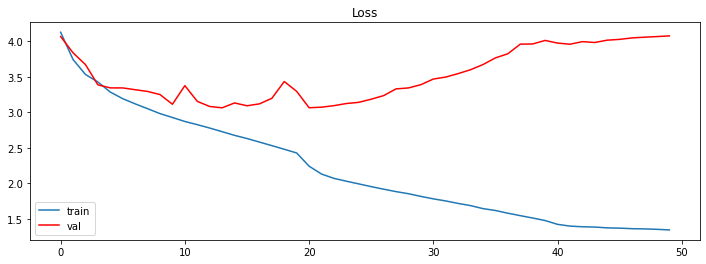

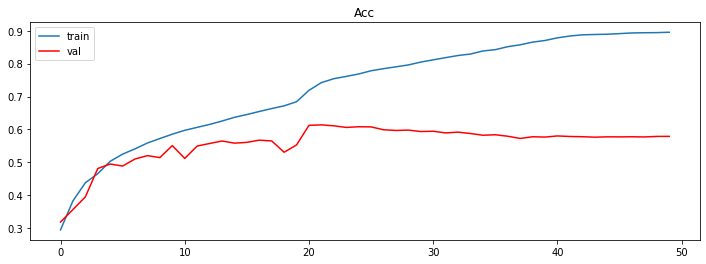

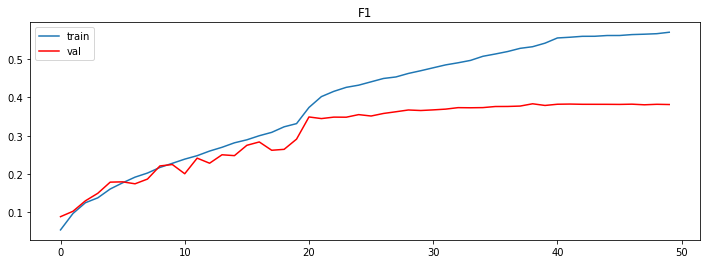

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_f1_list)), train_f1_list)
plt.plot(range(len(val_f1_list)), val_f1_list, c='r')
plt.legend(['train', 'val'])
plt.title('F1')
plt.show()

### Predict Result

Predict the labesl based on testing set. Upload to [Kaggle](https://www.kaggle.com/c/mis583-2021-flower-classification).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 70% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/c/mis583-2021-flower-classification)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [ ]:
# # if you wanna load previous best model
# ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/NSYSU IM/深度學習/Assignment4/assign4_ckpts/resnet50_e083_vacc_0.58_vf1_0.38_vloss_5.9.pt')
# model.load_state_dict(ckpt) 

In [ ]:
def predict_C(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for data in input_data:
            images = data.to(device)
            outputs = model(images)[0]
            _, predicted = torch.max(torch.softmax(outputs.data, 1), 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [ ]:
idx = 0
output_csv = predict_C(test_loader, model)
with open('result_C.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'category_label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx]
        writer.writerow({'file_path':file_path, 'category_label':result})
        idx += 1

In [ ]:
def predict_A(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)[1]
            predicted = (torch.sigmoid(outputs.data) > 0.25).int()
            index = []
            for img in range(len(predicted)):
                index = []
                for i in range(len(predicted[img])):
                    if(predicted[img][i]==1):
                        index.append(str(i))
                output_list.append(' '.join(index)) #轉成str
    return output_list

In [ ]:
idx = 0
output_csv = predict_A(test_loader, model)
print(output_csv)
with open('result_A.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'attribute_label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx]
        writer.writerow({'file_path':file_path, 'attribute_label':result})
        idx += 1

['4 9', '1 3', '8 10', '0 2', '7', '1', '0', '1', '6 9', '7', '0 10', '0 5', '0 2', '3 5 8', '0', '6 14', '1', '1', '6 9', '1 4 13', '0 2 3', '1 3', '7 9', '1', '3', '1 3', '11 12', '6 14', '0 2', '0 2', '0 2', '1', '4 13', '0 2 10', '1', '0', '10', '0 2', '3 4', '0 9', '1', '0 2 8', '0 2', '6 14', '1 10', '7', '0 3 6 14', '0 2', '0 3 5', '1', '4', '0 2', '3', '1', '0 10', '0 6 9', '', '11 12', '3 4', '7', '4 13', '', '0', '0', '0', '6 9', '0 2', '0 2', '5', '2 4', '0 5', '1', '0', '2 4', '4 7 10 13', '5 12', '5', '8', '7', '', '4 10 13', '6 14', '4', '0 2 9', '0', '8 9', '1 4', '2 4', '0 2 8', '4', '0', '3', '11 12', '11', '1', '2 3 4 8', '6 10', '5', '2 13', '', '0 2', '0', '2 4 10 13', '0 3', '1 3', '7 9', '1 13', '2 4', '7', '1 6', '0 2', '5', '0', '0', '6', '1', '1 13', '1 3', '0 9', '3 6 9 14', '0 1', '0 8', '2 4', '5', '2 4 13', '1 9 11 12', '6 14', '2 4 13', '1 14', '11 12', '7', '10', '0 2 12', '14', '1 6', '0', '6 14', '1 3', '1 5', '8 10', '0 2 8', '', '13', '1', '2 4', '7',